# RBF Interpolation: Introduction and 1D example
This is a project I started in Fall of 2017 as an offshoot of a much larger collaborative research project. The overall project goal was looking to improve the efficieny of mapping an unknown terrain for task-driven navigation purposes. The design philosophy was basically that most of the time, it is not necessary to map the entire field of interest down to extreme accuracy, just specific sub-sections of the field that you are confident you will be navigating through.

My part focused on attempting to interpolate real-world data for demonstration purposes. The terminology used in the project was that we would be mapping "threat fields," but the interpretation of "threat field" was left ambiguous. This notebook introduces RBF interpolation and provides a 1D applied example.

First, the necessary basic imports:

In [183]:
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import lsmr
plt.ion()

The basic problem formulation of raial basis function(RBF) interpolation is that any data-field can be expressed as a weight combination of radially symetric basis functions. The basis functions I will be using in this example are all Gaussian functions. RBF interpolation is particularly useful as it tends to be very good with handling sparse data-sets. The larger scope of this project was to utilize this characteristic by intelligently selecting data points to interpolate.

With any complicated spatial mathematics problem, I think it is best practice to get a firm understanding of the 1D problem before extending any models to the 2D problem. First we need to define the general form of our basis function (often called the "kernel").

In [184]:
def gaussian(r, eps):
    '''
    One-dimensional gaussian basis function
    :param r: radial distance of data point to basis center, can also be array-like
    :param eps: sometimes expressed as 1/sigma, basically controls the width of the basis
    :return: evaluation of the basis function at the given point(s)
    '''
    return np.exp(-(eps*r)**2)

The first question of RBF interpolation is where to place the bases. For the 1D example, it is suitable to evenly distribute a number of bases over the field of interest. To get a visual representation of this, lets plot 10 basis functions over an interval:

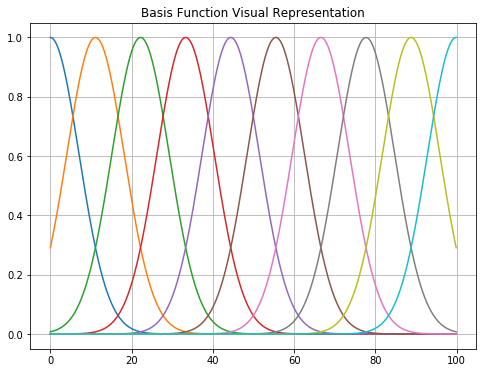

In [185]:
field = np.arange(0,100,.1)
num_bases = 10
basis_centers = np.linspace(0, field[-1], num_bases)
sigma = (field.max()-field.min())/num_bases
basis_fig = plt.figure(figsize=(8,6))
for i in range(num_bases):
    plt.plot(field, gaussian(field-basis_centers[i],1/sigma))

plt.grid()
plt.title('Basis Function Visual Representation');

It's clear to see that by appropriately weighting each of these basis functions, we could sum them up to closely fit any continuous data set defined on the field. Let's see how they model a simple sin function.

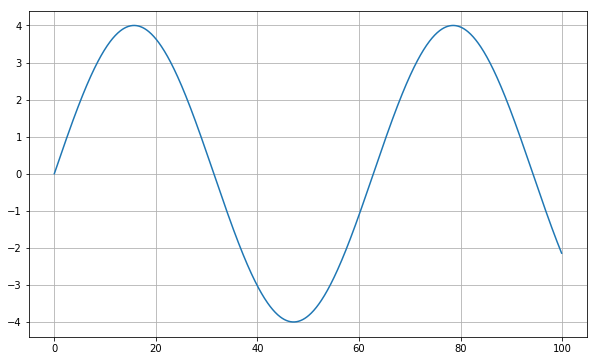

In [186]:
true_field = 4*np.sin(field/10)
plt.figure(figsize=(10,6))
plt.plot(field,true_field)
plt.grid()

The second question we must answer is how to properly weight the bases. For the 1D case, least-squares regression is a suitable estimation method. But first we need to set up the matrix equation PHI * w = z, where PHI(i,j) is the evaluation of basis function j at x_i, z_i is the true field value at x_i, and w_j is the weight to be assigned to basis function j. First let's randomly select a few points along the sine curve to interpolate.

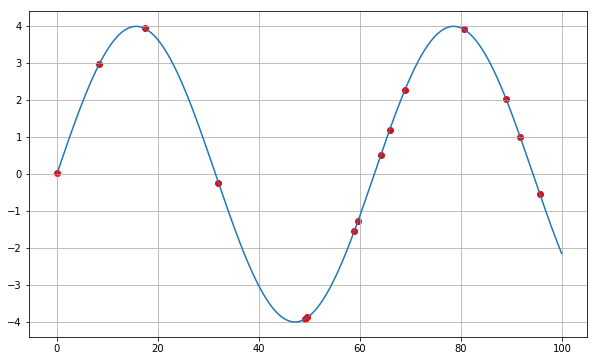

In [187]:
num_data = 15
xind = np.random.randint(0, len(field), num_data)
xvals = field[xind]
zvals = true_field[xind]
plt.figure(figsize=(10,6))
plt.plot(field,true_field)
plt.scatter(xvals,zvals, c='r')
plt.grid()

Now we need to create the PHI matrix by evaluating each basis function at each data point.

In [188]:
PHI = np.zeros((num_data,num_bases))
for i in range(num_data):
    for j in range(num_bases):
        PHI[i,j] = gaussian(abs(xvals[i]-basis_centers[j]),1/sigma)
print(np.round(PHI,3))

[[0.    0.    0.    0.    0.    0.    0.002 0.14  0.919 0.51 ]
 [0.048 0.672 0.794 0.079 0.001 0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.002 0.165 0.948 0.46  0.019 0.   ]
 [0.    0.    0.    0.    0.    0.002 0.144 0.924 0.501 0.023]
 [0.    0.    0.    0.    0.02  0.477 0.939 0.157 0.002 0.   ]
 [1.    0.297 0.007 0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.001 0.079 0.794 0.672 0.048 0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.007 0.285 1.    0.297]
 [0.493 0.93  0.148 0.002 0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.001 0.122 0.891 0.552 0.029 0.    0.   ]
 [0.    0.    0.    0.    0.01  0.338 0.995 0.248 0.005 0.   ]
 [0.    0.    0.001 0.07  0.763 0.706 0.055 0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.04  0.629 0.831]
 [0.    0.    0.    0.001 0.099 0.845 0.612 0.038 0.    0.   ]
 [0.    0.013 0.382 0.983 0.214 0.004 0.    0.    0.    0.   ]]


Examination of the PHI matrix demonstrates the power of gaussian basis function. Because gaussian functions decay to 0 relatively quickly outside their center, most matrix values here are close to 0. This allows for only basis functions which are close to data points to be weighted in the regression. Now let's carry out the LSQ regression, compute the interpolated field, and plot all calculated curves and scatters.

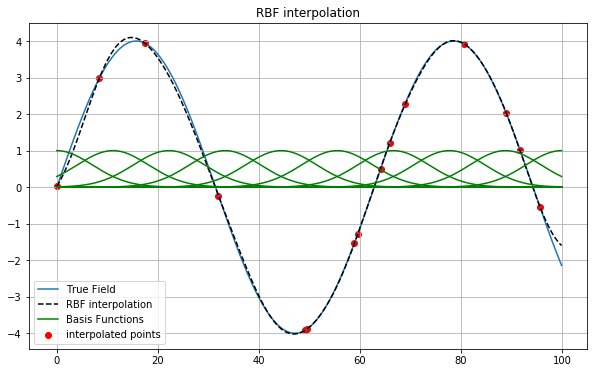

In [189]:
w = np.linalg.inv(PHI.T.dot(PHI)).dot(PHI.T).dot(zvals.T)
field_approx = np.zeros(len(field))
for i in range(num_bases):
    field_approx += w[i]*gaussian(abs(field-basis_centers[i]),1/sigma)
    
plt.figure(figsize=(10,6))
plt.plot(field,true_field,label='True Field')
plt.scatter(xvals,zvals,c='r',label='interpolated points')
plt.plot(field, field_approx, 'k--',label='RBF interpolation')
for i in range(num_bases-1):
    plt.plot(field, gaussian(field-basis_centers[i],1/sigma),'g')
plt.plot(field,gaussian(field-basis_centers[-1],1/sigma),'g',label='Basis Functions')
plt.legend()
plt.grid()
plt.title('RBF interpolation');

That interpolation was pretty good! The interpolation is almost exactly the same as the true field, using only 15% of the data. Granted the original function is pretty smooth and easy to guess, but it still demonstrates the capabilities of RBF interpolation when dealing with sparse data. The following function generalized this process for any given field, data set, and number of bases.

In [190]:
def rbfInterp1d(field, xvals, zvals, num_bases, plot=True):
    '''
    Radial Basis function interpolation of one-dimensional data
    :param data_points: 2xn array, 1st row x values, 2nd row y/z values
    :param n_bases: number of bases to use in interpolation
    :param plot: if plot of the interpolation is desired
    :return:
    '''
    
    # if over-determined, use regularized least squares
    # in the case of over-fitting, the approximated field will often shoot off to major
    if num_bases>len(xvals): regularize=True
    else: regularize=False
    
    num_data = len(xvals)
    # define basis centers and spacing parameter
    sigma = (field.max()-field.min())/num_bases
    basis_centers = np.linspace(0, field[-1], num_bases)
    
    # Approximation is defined by the matrix equation PHI * w = z
    # creation of the PHI matrix, where PHI[i,j] = rbf[j] evaluated at x_i
    PHI = np.zeros((num_data,num_bases))
    for i in range(num_data):
        for j in range(num_bases):
            PHI[i,j] = gaussian(abs(xvals[i]-basis_centers[j]),1/sigma)

    # least squares approximation formula
    if(regularize): w = lsmr(PHI,zvals)[0]
    else: w = np.linalg.inv(PHI.T.dot(PHI)).dot(PHI.T).dot(zvals.T)
    
    # generate the field approximation
    field_approx = np.zeros(len(field))
    for i in range(num_bases):
        field_approx += w[i]*gaussian(abs(field-basis_centers[i]),1/sigma)
    
    # plot values
    if plot:
        plt.figure(figsize=(10,6))
        plt.plot(field,true_field,label='True Field')
        plt.scatter(xvals,zvals,c='r',label='interpolated points')
        plt.plot(field, field_approx, 'k--',label='RBF interpolation')
        for i in range(num_bases-1):
            plt.plot(field, gaussian(field-basis_centers[i],1/sigma),'g')
        plt.plot(field,gaussian(field-basis_centers[-1],1/sigma),'g',label='Basis Functions')
        plt.legend()
        plt.grid()
        plt.title('RBF interpolation')
    return field_approx

We can first just check that this function will run the same on the data we just used.

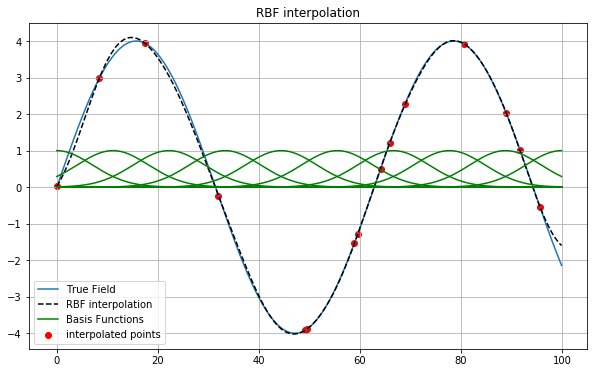

In [191]:
rbfInterp1d(field,xvals,zvals, num_bases);

We could also test to see how the interpolation does when it's passed fewer points. Lets try to just pick 5 of the points we passed.

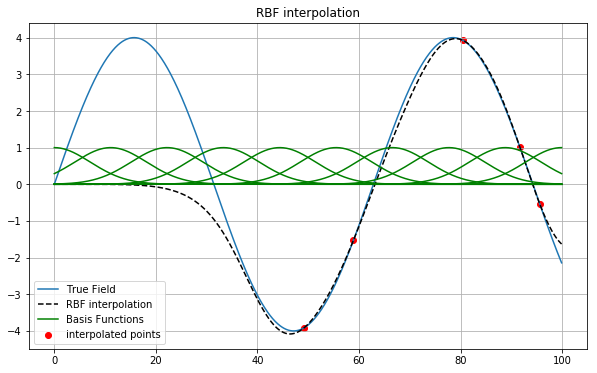

In [192]:
rbfInterp1d(field,xvals[0:14:3], zvals[0:14:3], 10);

In the case of an overdetermined systems (where there are more bases than data points), we need to utilize regularized least squares, included in the lsmr function call. This sets limits on the weights to prevent overfitting, as in these cases the approximate field with directly pass through all data points, but will drastically shoot over or under the true field in the intermediate regions.

This wraps up the one-dimensional example. Check out the other notebook for my attempts to solve a 2D interpolation problem.